# <center>Comparison of predicted class probabilities across models for binary classifiers</center>


This study aims at comparing binary classifiers on the basis of their prediction "confidence" as quantified by predicted probabilities. The vehicles.csv dataset that has been used so far requires multiclass classification because its response variable has 4 classes. In order to carry out this study, a bi-class dataset was needed so there were two possible approaches:
The first approach considers adjusting the vehicles.csv dataset by dropping all but two classes.

In [1]:
import warnings

#import customised modules
import k_nn
import compare_estimators
from load_dataset import load_dataset

#Data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#machine learning libraries; import scikit learn
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

The warnings in this notebook are ignored for aesthetic in order to make it aesthetically pleasing.

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Loading and preprocessing of the dataset

### Method 1
The vehicles.csv dataset is used. It's target variable has four possible classes `['bus' 'opel' 'saab' 'van']` as observed by running `np.unique(target)`. However, the initial phase of this study is centered on binary classification and so the dataset is modified such that only two classes are left.

In [3]:
#Data set is loaded into a pandas dataframe
filename = "vehicles.csv"
df = load_dataset(filename)

"""Remove all observations that do not belong to either class 'opel' or class 'bus'. 
The choice of the classes to evaluate was arbitrary."""

opel = df["Class"]=='opel'
bus = df['Class']=='bus'

print("The initial shape of the dataset is {}".format(np.shape(df)))

df = df[bus | opel]
print("The new shape of the dataset is {}".format(np.shape(df)))

#Separate the feature and response variables of the dataset.
data = df.drop("Class", axis=1)
target = df["Class"]

print("The classes of the target variable after adjustment are {}".format(np.unique(target)))


The initial shape of the dataset is (846, 19)
The new shape of the dataset is (430, 19)
The classes of the target variable after adjustment are ['bus' 'opel']


It is noticed that 416 observations were lost, accounting for 49 percent of the dataset. This is a significant chunk of data and considering that the new dataset has far less than 10,000 samples, there is a high risk of underfitting. Therefore, for this study, the `defaults.csv` dataset is used instead which has just two classes.

### Method 2

The defaults.csv dataset is loaded into a pandas dataframe using the `load_dataset` module. Its target variable (`defaulted`) is then separated from the independent variables and the `train_test_split` function from the `model_selection` module of scikit learn is used to split the dataframe content into training and test sets. The train/test ratio used is 70/30.

In [4]:
filename = "defaults.csv"
df = load_dataset(filename)

data = df.drop("defaulted", axis=1)
target = df["defaulted"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.30, stratify=target, random_state=42)
data_train = scale(data_train)
data_test = scale(data_test)

# Part one : Visualising predicted class probabilities.

## KNN
A KNN model is fitted to the training set. A tuned value of the `n_neighbors` hyperparameter is used to ensure optimum results. The arrangement of the classes is observed using the `.classes_` attribute. This eases the understanding of the results that will be produced by `predict_proba` later on.

In [5]:
n = int(k_nn.tune(data_train, target_train))
""" The param_val value is converted from the numpy.int64 type to an integer in order to make it appropriate
for use as a parameter of the classifier."""
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(data_train, target_train)
print(knn.classes_)

[0 1]


The classes are arranged such that class0 comes before class1. Hence in the results of `predict_proba`, the first column will be the probability that the sample belongs to class0 while the second column will be the probability that the sample belongs to class1. In this study, **class1 is considered the positive class** .

### Exploring predict_proba()

For binary classification, predict_proba returns two columns. Considering the previous statements, the first column is the represents the probability of `False` and the second column represents the probability of `True` (This is because the second column represents the probability of class1 and class1 is considered the positive class).

In [6]:
pred_prob_knn_full=knn.predict_proba(data_test)
pred_prob_knn = knn.predict_proba(data_test)[:,1]

In [7]:
print("The shape of the test data is {}".format(np.shape(data_test)))
print("predict_proba returns an object of shape {} ".format(np.shape(pred_prob_knn_full)))
print("predict_proba returns an object of shape {} and type {} with dimensions {}".format(np.shape(pred_prob_knn_full), type(pred_prob_knn_full), np.ndim(pred_prob_knn_full)))

The shape of the test data is (9000, 24)
predict_proba returns an object of shape (9000, 2) 
predict_proba returns an object of shape (9000, 2) and type <class 'numpy.ndarray'> with dimensions 2


It is observed that the shape of the test data is `(n_samples, n_features)`, and that predict_proba() returns a two dimensional numpy array of shape `(n_samples, n_classes)`. The `predict_proba()` function returns a list of list; one list per observation.
The index 1 values of predict_proba() are plotted in order to analyse the probability of being in the positive class.

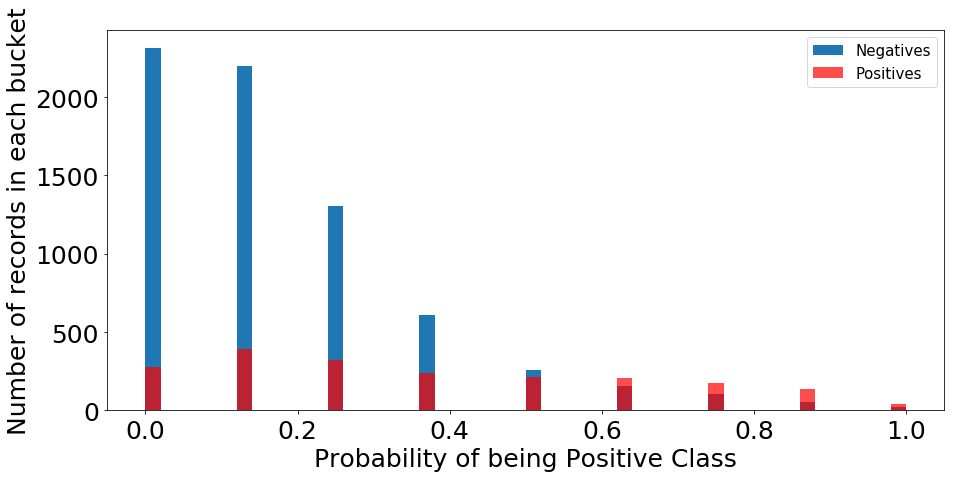

In [8]:
plt.figure(figsize=(15,7))
plt.hist(pred_prob_knn[target_test==0], bins=50, label='Negatives')
plt.hist(pred_prob_knn[target_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

It is observed that when the true values are negative, the predicted probability of being in the positive class tends to be really low. That is, the lower the probability of being in the positive class, the higher the tendency that that sample actually belongs to the negative class.
However, when the true values are positive(red), the model still seems to have very little confidence in its prediction. This is because a chunk of the samples which have true positive values are still predicted with very low probability.
Overall, the KNN model has a low confidence level with respect to the `defaults.csv` dataset.

## Logistic Regression
The class probabilities when a logistic regression model was used were observed.

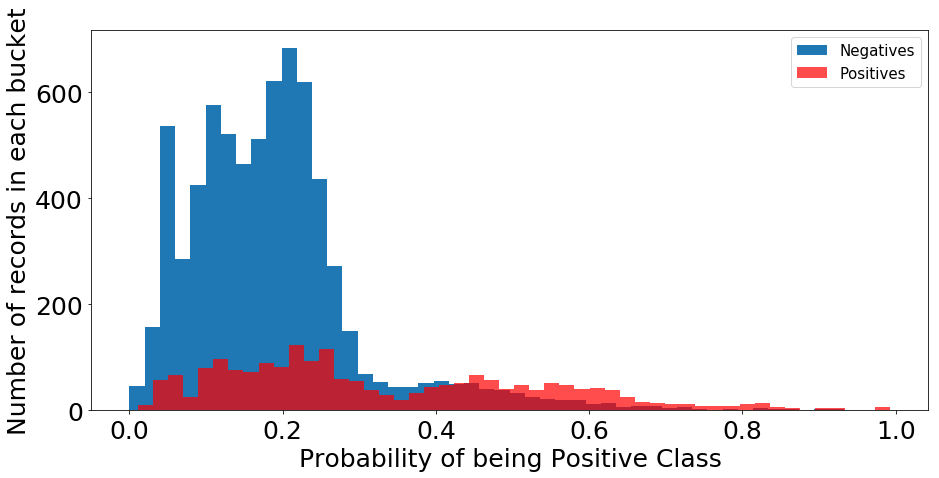

In [9]:
lr=LogisticRegression(random_state=0, solver='lbfgs', max_iter=7600)
lr.fit(data_train, target_train)

pred_prob_lr=lr.predict_proba(data_test)[:,1]

plt.figure(figsize=(15,7))
plt.hist(pred_prob_lr[target_test==0], bins=50, label='Negatives')
plt.hist(pred_prob_lr[target_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## RandomForestClassifier

The mean score of the Random forest classifier on this dataset is 0.8073334123634613


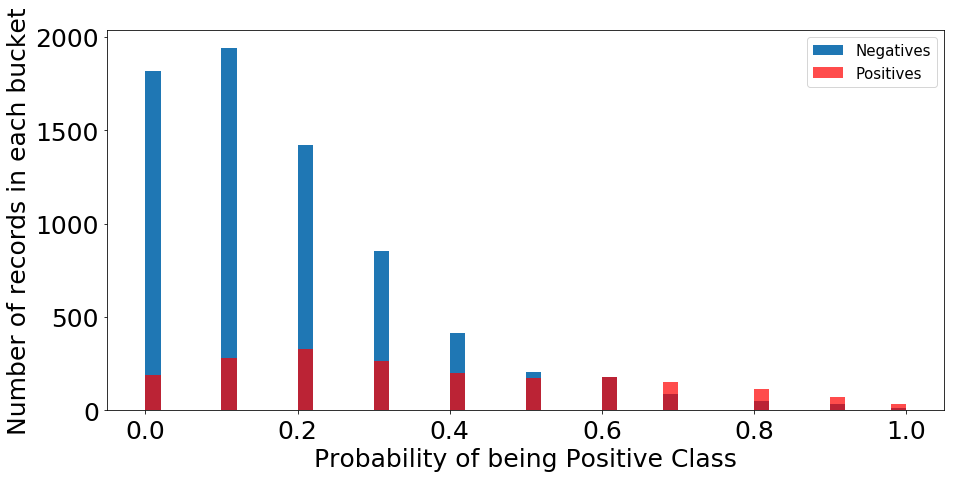

In [10]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=None,

    min_samples_split=2, random_state=0)

scores = cross_val_score(rfc, data_train, target_train)

print("The mean score of the Random forest classifier on this dataset is {}".format(scores.mean()))

classifier = rfc.fit(data_train, target_train)

pred_prob_rfc = classifier.predict_proba(data_test)[:,1]

plt.figure(figsize=(15,7))
plt.hist(pred_prob_rfc[target_test==0], bins=50, label='Negatives')
plt.hist(pred_prob_rfc[target_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

The random forest classifier is observed to have a high accuracy score. However, from the visualisation of its class probabilities in the preceding figure, it is observed that the random forest classifier predicts the positive class (class 1) with very low confidence.

It was noticed that in both models, negative values were predicted with much more surety than positive values. This is because the negative values are observed, as expected, to be very dominant in low probability buckets and totally absent in high probability buckets. Meanwhile the positive values are almost evenly spread out among the probalility buckets.
The true values (`target_test`) where explored in order to gain more insight into this behaviour.

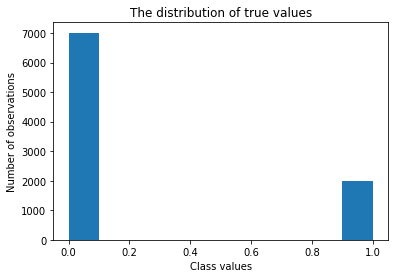

In [11]:
plt.hist(target_test)
plt.xlabel("Class values")
plt.ylabel("Number of observations")
plt.title("The distribution of true values")
plt.show()

It was noticed that the samples are grossly unevenly distributed among the classes. Hence, prediction models are observed to portray more confidence when predicting the more populous class (in this case, it is the negative class).

# Part two : Comparison of classifiers based on predicted probabilities

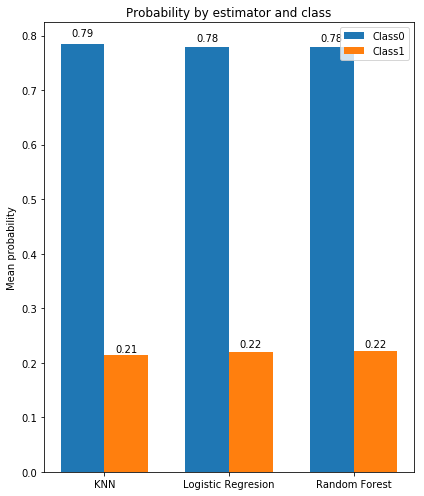

In [12]:
labels = ['KNN', 'Logistic Regresion', 'Random Forest']
estimators = [knn,lr,rfc]

compare_estimators.class_probs(labels, estimators, data_test)

The figure displays the class predicted probabilities per classifier. It is observed that there is a discrepancy in the K-nearest neighbors classifier with respect to the other two classifier. More insights about this will be gained subsequently.

## Side note
In order to give context, and ease the understanding of the first visualisations where the probability of being in the positive classs was observed, below is a demonstration of expected behaviour of a good model.

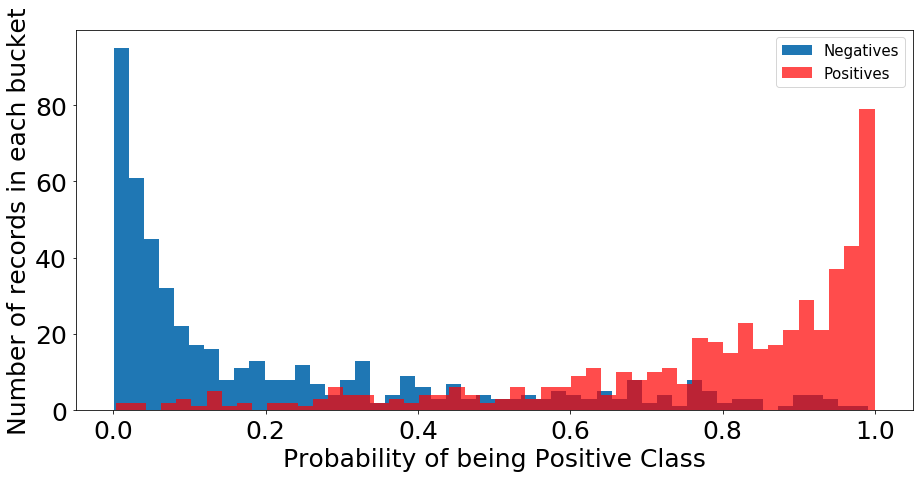

In [13]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=1, shuffle=False)
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(random_state=0, solver='lbfgs', max_iter=10)
lr.fit(X, y)

prediction=lr.predict_proba(X)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y==0], bins=50, label='Negatives')
plt.hist(prediction[y==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

However, in a totally ideal case, there will be no negatives at all, or all the negatives will have a predicted probability of zero.